In [1]:
import json
import numpy as np
import pandas as pd

import MeCab

import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

from PIL import Image
from os import path

In [2]:
stories_json = []
with open('./output_stories.json', 'r') as f:
    stories_json = stories_json + json.loads(f.read())

print(len(stories_json))
print(stories_json[1].keys())

398
dict_keys(['index', 'title', 'abstracts_list'])


In [3]:
stories_df = pd.DataFrame(stories_json)
stories_df["abstract_joined"] = stories_df["abstracts_list"].str.join(" ")
stories_df.head()

,index,title,abstracts_list,abstract_joined
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,[ 何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいな...,何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいない...
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],[ ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。この...,ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。このコ...
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],[ スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとする...,スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとするが...
3,0328,「ひるねは天国で」「どくさいスイッチ」[2013年5月3日放送],[ のび太とドラえもんが部屋で昼寝をしていると、突然大きな音が聞こえてくる。となりの家が改築...,のび太とドラえもんが部屋で昼寝をしていると、突然大きな音が聞こえてくる。となりの家が改築工...
4,0329,「インスタントママ」「狙われたジャイアン」[2013年5月10日放送],[ そうじにせんたく、町内会の会合と毎日大忙しのママが、「体がもうひとつほしい」とため息をつ...,そうじにせんたく、町内会の会合と毎日大忙しのママが、「体がもうひとつほしい」とため息をつい...


In [4]:
t = MeCab.Tagger('-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')
def mecab_tokenizer(text):
    parsed_lines = t.parse(text).split("\n")[:-2]
    surfaces = [l.split('\t')[0] for l in parsed_lines]
    features = [l.split('\t')[1] for l in parsed_lines]
    # 原型を取得
    bases = [f.split(',')[6] for f in features]
    # 品詞を取得
    pos = [f.split(',')[0] for f in features]

    # 各単語を原型に変換する
    token_list = [b if b != '*' else s for s, b in zip(surfaces, bases)]
    # 瀕死を絞り込み
    target_pos = ["名詞"]
    token_list = [t for t, p in zip(token_list, pos) if p in target_pos]
    # アルファベットを小文字に統一
    token_list = [t.lower() for t in token_list]

    return [ text for text in filter(lambda x: not x.isascii(), token_list)]

In [5]:
# ストーリーが取得できたものに絞る
stories_df = stories_df[stories_df['abstract_joined'].str.len() > 0] 
sentences = stories_df["abstract_joined"].apply(mecab_tokenizer)
print(sentences)

0      [何, のび太, 魔法, 魔法, 便利, ちがい, もしもボックス, 現実, 世界, 魔法,...
1      [朝, 寝坊, のび太, ドラえもん, 爆発, コショウ, コショウ, 行き先, そば, 人...
2      [スネ夫, ハワイ旅行, じまん, のび太, 自分, ハワイ, ママ, 給料日, 前, お金...
3      [のび太, ドラえもん, 部屋, 昼寝, 音, となり, 家, 改築, 工事, の, しずか...
4      [そうじ, せんたく, 町内会, 会合, 毎日, 大忙し, ママ, 体, ひとつ, ため息,...
                             ...                        
393    [毎日, 勉強, テレビ, マンガ, 昼寝, のび太, パパ, 自分, しょうらい, ん, ...
394    [雲, ガス, 雲の上, 昼寝, のび太, しずか, 幸せ, 生活, 夢, 幸せ, 気持ち,...
395    [のび太, 部屋, 中, ゴリラ, ビックリ, 手, ビン, フタ, ドラえもん, ゴリラ,...
396    [スネ夫, 最新, リモコン, カー, レース, のび太, 昔, ボロボロ, リモコン, カ...
397    [明日, ドラえもん, 誕, たん, 生, 日, みんな, どら焼き, たくさん, 用意, ...
Name: abstract_joined, Length: 398, dtype: object


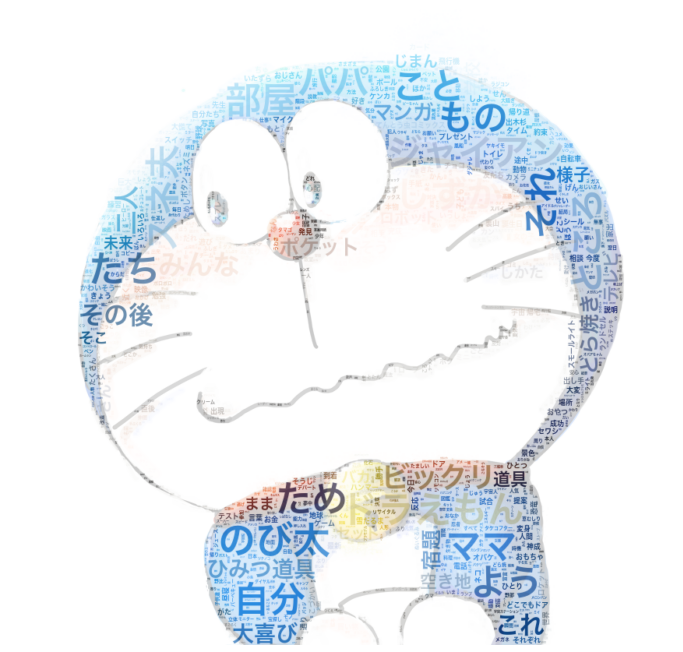

<Figure size 432x288 with 0 Axes>

In [6]:
text = sentences.agg(' '.join).values
dora_coloring = np.array(Image.open(path.join("sample-dora.png")))

FONT_PATH = "/System/Library/Fonts/ヒラギノ角ゴシック W6.ttc"
wordcloud = WordCloud(
    width=2500, 
    height=2500, 
    background_color='white', 
    mask=dora_coloring,
    prefer_horizontal=0.75,
    relative_scaling=0,
    min_word_length=2,
    min_font_size=2,
    max_font_size=48,
    max_words=10000,
    repeat=False,
    # remove duplicates
    collocations=False,
    font_path=FONT_PATH
).generate(str(' '.join(text)))

image_colors = ImageColorGenerator(dora_coloring)
dora_img = Image.open(path.join("sample-dora.png"))
dora_coloring = np.array(dora_img)

plt.figure(figsize=(12,12))

plt.imshow(dora_img, alpha=.8)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear", alpha=0.75)
plt.axis('off') #軸の表示を消す
plt.show()

plt.savefig('output.png')